[Google Colabで実行](https://colab.research.google.com/github/genkuroki/public/blob/main/0054/plot%20P-values.ipynb)

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd using Distributions
@autoadd using Plots
default(fmt=:png, legendfontsize=12, guidefontsize=12, titlefontsize=12)

In [2]:
rd(x) = round(x; sigdigits=3)
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_bin_score(k, n, p)
    phat = k/n
    se = sqrt(p*(1-p)/n)
    z = safediv(phat - p, se)
    2ccdf(Normal(), abs(z))
end

svalue_bin_score(k, n, p) = -log2(pvalue_bin_score(k, n, p))

function plot_pvalue_bin!(; k=14, n=20, xann=0.49, yann=0,
        label="", c=:auto, ls=:solid, lw=1, shownullpval=false, kwargs...)
    nullpval = pvalue_bin_score(k, n, 0.5)
    plot!(p -> pvalue_bin_score(k, n, p), 0, 1; label, c, ls, lw)
    if shownullpval
        vline!([0.5]; ls=:dot, lw=0.5, c=:black, label="")
        scatter!([0.5], [nullpval]; label="", msc=:auto, c=:black)
        annotate!(xann, nullpval+yann,
            text("P-value of p=0.5: $(rd(100nullpval))%", :right, :black, 11))
    end
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    plot!(xguide="p = c", yguide="P-value = compatibility")
    title!("data: heads k=$k times in n=$n coin tosses")
    plot!(; kwargs...)
end

function plot_pvalue_bin(; k=14, n=20, xann=0.495, yann=0.02,
        label="", c=:auto, ls=:solid, lw=1, shownullpval=false, kwargs...)
    plot()
    plot_pvalue_bin!(; k, n, xann, yann, label, c, ls, lw, shownullpval, kwargs...)
end

function plot_svalue_bin!(; k=14, n=20, label="", c=:auto, ls=:solid, lw=1, kwargs...)
    nullsval = svalue_bin_score(k, n, 0.5)
    ps = range(0, 1, 1001)
    plot!(ps, p -> svalue_bin_score(k, n, p); label, c, ls, lw)
    plot!(ylim=(-0.3, 10.3))
    plot!(xtick=0:0.1:1, ytick=0:0.5:10)
    plot!(xguide="p = c", yguide="S-value = surprise\n  = −log₂ P-value")
    title!("data: heads k=$k times in n=$n coin tosses")
    plot!(; kwargs...)
end

function plot_svalue_bin(; k=14, n=20, label="", c=:auto, ls=:solid, lw=1, kwargs...)
    plot()
    plot_svalue_bin!(; k, n, label, c, ls, lw, kwargs...)
end

function plot_pval_sval(; k=14, n=20, yann=0.04, kwargs...)
    P = plot_pvalue_bin(; k, n, yann, shownullpval=true, kwargs...)
    Q = plot_pvalue_bin(; k, n, yann, shownullpval=false, kwargs...)
    R = plot_svalue_bin(; k, n, kwargs...)
    plot(P, Q, R; size=(700, 1000), layout=(3, 1), leftmargin=10Plots.mm)
end

plot_pval_sval (generic function with 1 method)

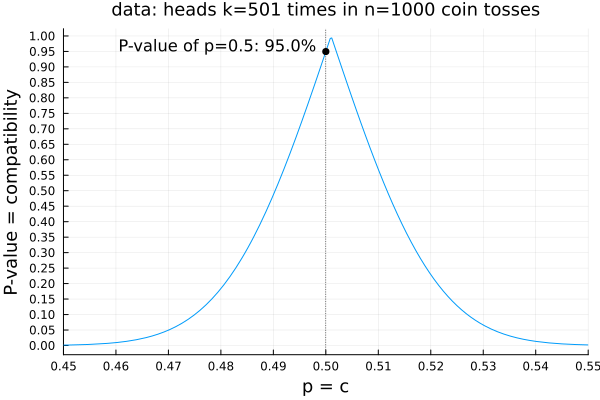

In [3]:
plot_pvalue_bin(; k=501, n=1000, xlim=(0.45, 0.55), xann=0.498, xtick=0:0.01:1, shownullpval=true)

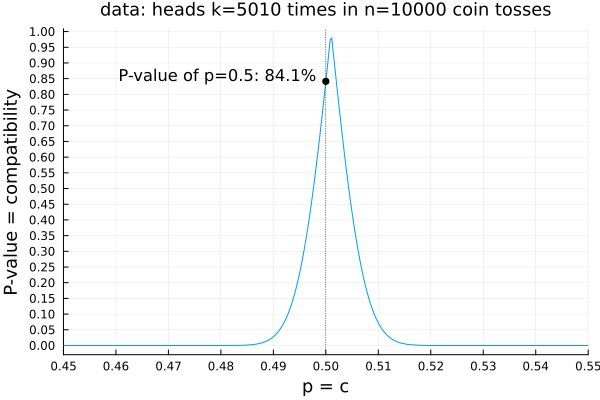

In [4]:
plot_pvalue_bin(; k=5010, n=10000, xlim=(0.45, 0.55), xann=0.498, xtick=0:0.01:1, shownullpval=true)

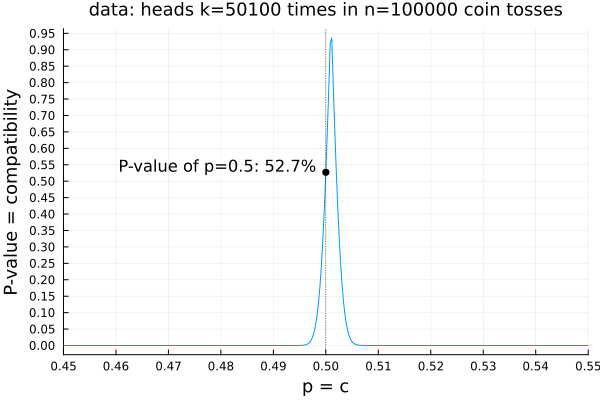

In [5]:
plot_pvalue_bin(; k=50100, n=100000, xlim=(0.45, 0.55), xann=0.498, xtick=0:0.01:1, shownullpval=true)

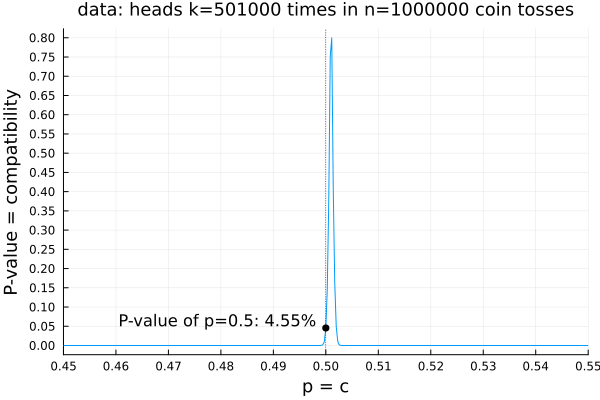

In [6]:
plot_pvalue_bin(; k=501000, n=10^6, xlim=(0.45, 0.55), xann=0.498, xtick=0:0.01:1, shownullpval=true)

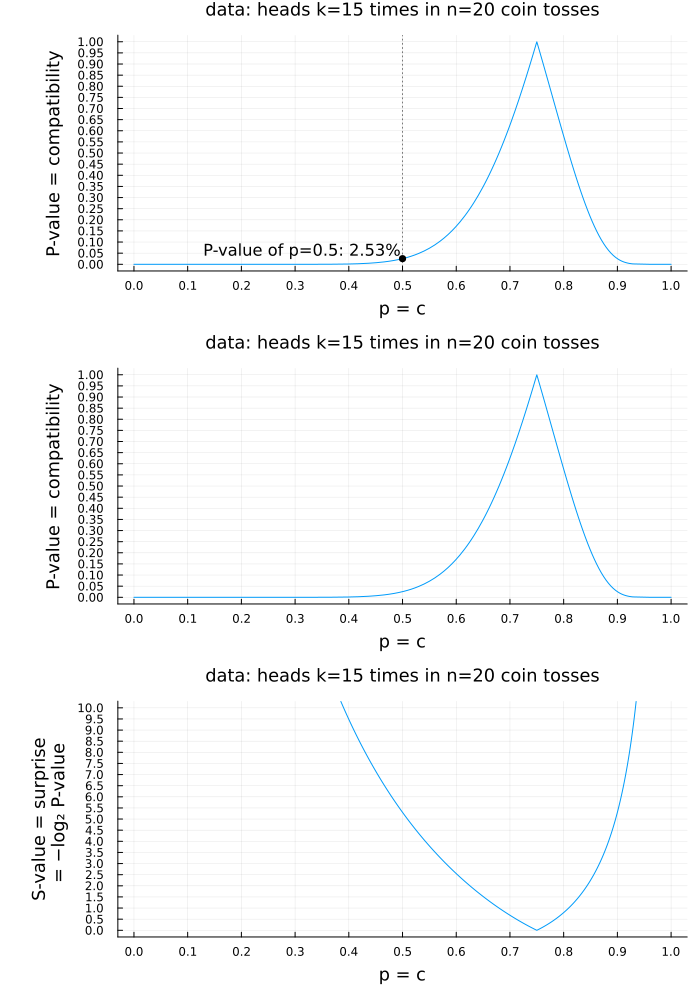

In [7]:
plot_pval_sval(; k=15, n=20)

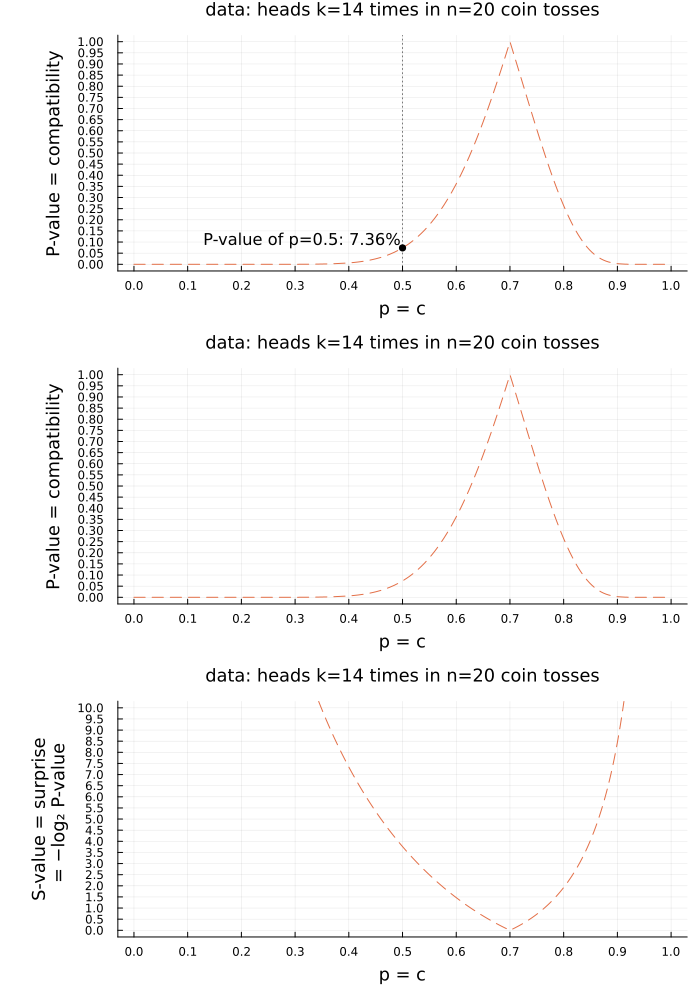

In [8]:
plot_pval_sval(; k=14, n=20, c=2, ls=:dash)

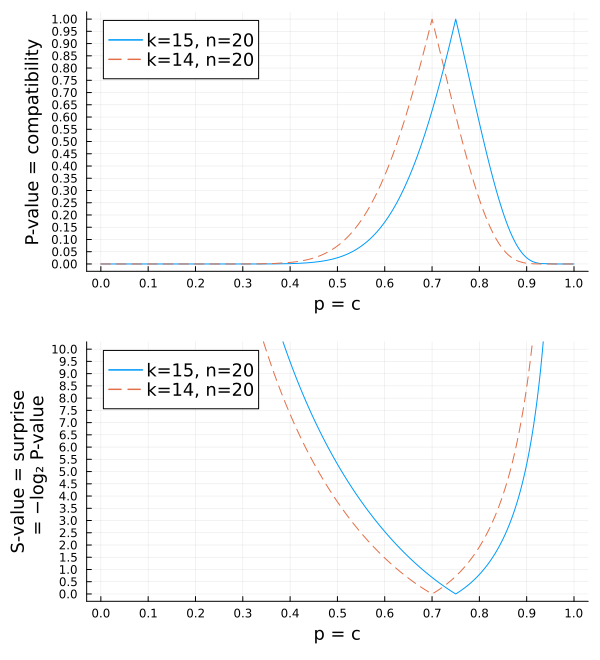

In [9]:
P = plot_pvalue_bin(; k=15, n=20, title="", label="k=15, n=20")
plot_pvalue_bin!(; k=14, n=20, title="", ls=:dash, label="k=14, n=20", legend=:topleft)
Q = plot_svalue_bin(; k=15, n=20, title="", label="k=15, n=20")
plot_svalue_bin!(; k=14, n=20, title="", ls=:dash, label="k=14, n=20", legend=:topleft)
plot(P, Q; size=(600, 660), layout=(2, 1))

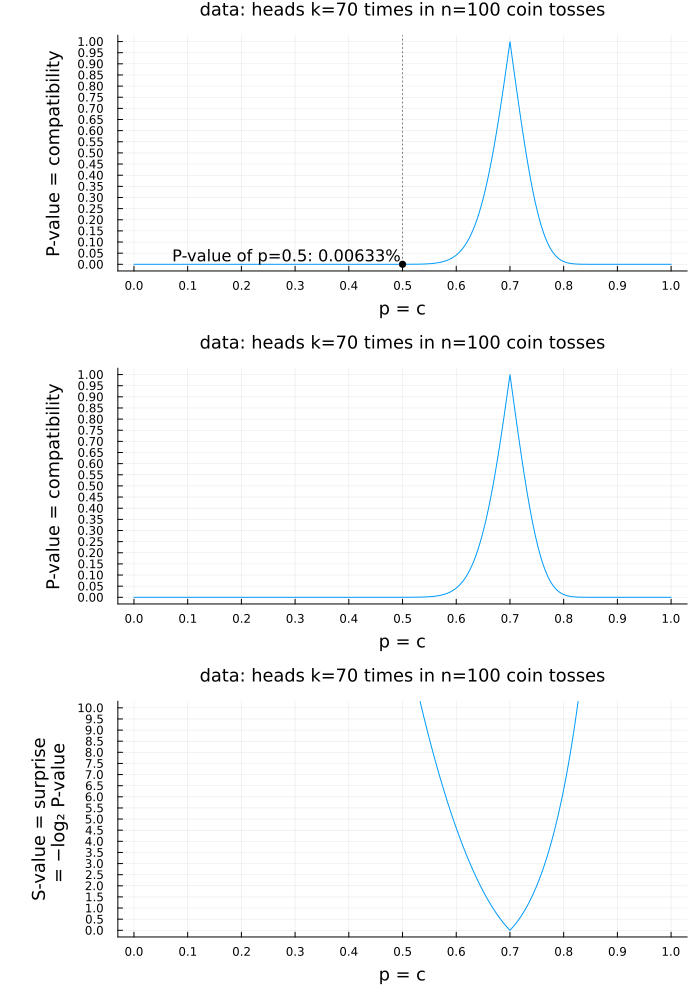

In [10]:
plot_pval_sval(; k=70, n=100)

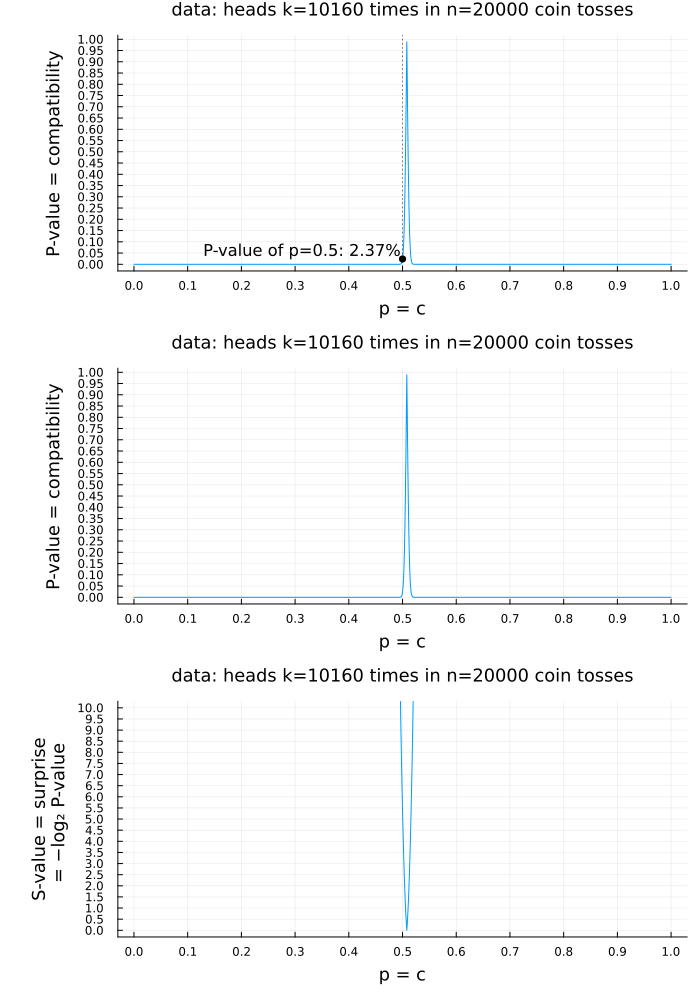

In [11]:
plot_pval_sval(; k=10160, n=20000)

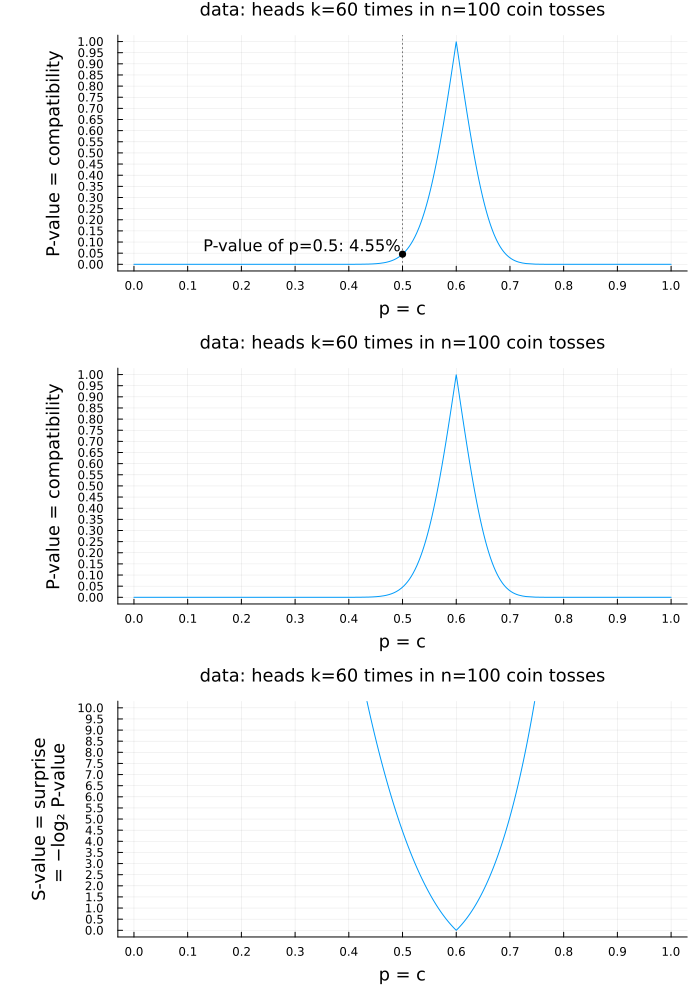

In [12]:
plot_pval_sval(; k=60, n=100)

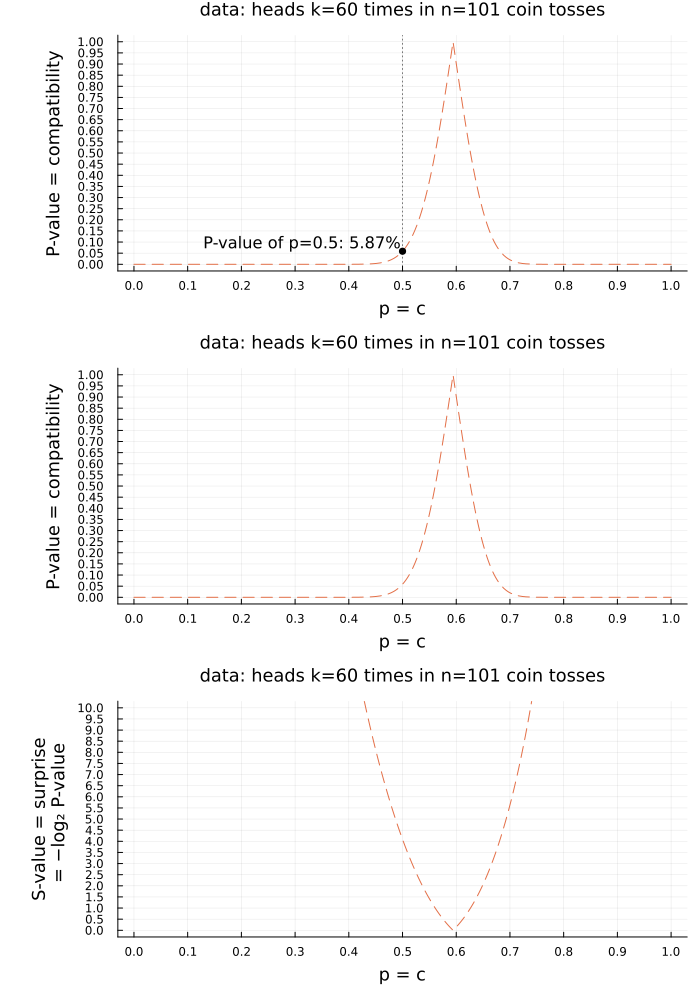

In [13]:
plot_pval_sval(; k=60, n=101, c=2, ls=:dash)

pvalue_bin_score(60, 100, 0.5) = 0.04550026389635844
pvalue_bin_score(60, 101, 0.5) = 0.05868167972817263

svalue_bin_score(60, 100, 0.5) = 4.457981276971884
svalue_bin_score(60, 101, 0.5) = 4.09094602188508



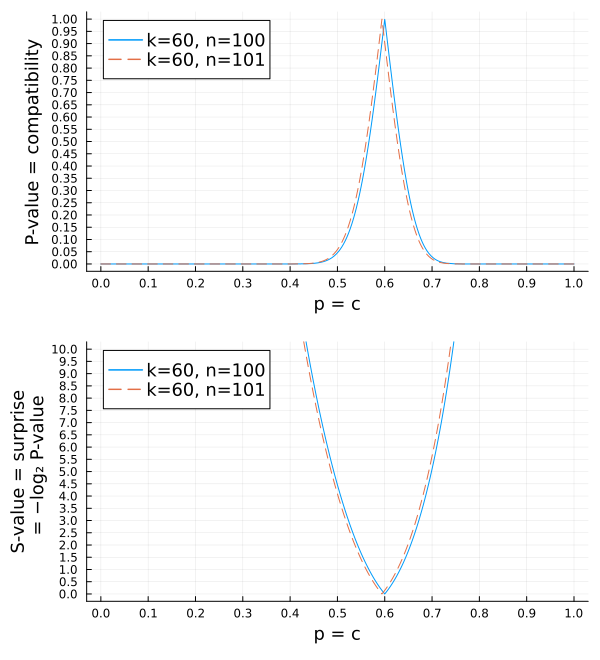

In [14]:
@show pvalue_bin_score(60, 100, 0.5)
@show pvalue_bin_score(60, 101, 0.5)
println()
@show svalue_bin_score(60, 100, 0.5)
@show svalue_bin_score(60, 101, 0.5)
println()
P = plot_pvalue_bin(; k=60, n=100, title="", label="k=60, n=100")
plot_pvalue_bin!(; k=60, n=101, title="", ls=:dash, label="k=60, n=101", legend=:topleft)
Q = plot_svalue_bin(; k=60, n=100, title="", label="k=60, n=100")
plot_svalue_bin!(; k=60, n=101, title="", ls=:dash, label="k=60, n=101", legend=:topleft)
plot(P, Q; size=(600, 660), layout=(2, 1))